## Next-to-do: MODEL SET1, AUC/ROC score, feature engineering/selection, and metric evaluation.
*To think about: imputation, y_train false/true instead of 1/0*

# Submission Information:

### Team Member 1:
* UNI:  mmt2167
* Name: Moorissa Tjokro

### Team Member 2:
* UNI:  jwh2163
* Name: Jager Hartman

# Task:

A banking institution ran a direct marketing campaign based on phone calls. Often, more than
one contact to the same client was required, in order to assess if the product (bank term
deposit) would be subscribed or not. Your task is to predict whether someone will subscribe to
the term deposit or not based on the given information.

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)

### 1. Load data and convert unknowns to nulls
Unknown values in the dataset seem to be clean and consistent, encoded as `unknown`. In this case, we can convert them to null values while importing the data.

In [2]:
data = pd.read_csv('data/data.csv', delimiter = ',', na_values='unknown')
data.head()

age           job marital_status          education credit_default  \
0  41.0   blue-collar        married           basic.9y             no   
1  46.0  entrepreneur        married                NaN             no   
2  56.0    unemployed        married           basic.9y             no   
3  89.0       retired       divorced           basic.4y             no   
4  34.0  entrepreneur        married  university.degree            NaN   

  housing loan   contact month day_of_week     ...      campaign  prev_days  \
0     yes   no  cellular   apr         mon     ...           2.0        999   
1      no   no  cellular   may         wed     ...           2.0        999   
2     yes  yes  cellular   nov         fri     ...           1.0        999   
3     yes   no  cellular   may         wed     ...           4.0        999   
4     yes   no  cellular   jul         thu     ...           8.0        999   

   prev_contacts  prev_outcomes emp_var_rate  cons_price_idx  cons_conf_idx  \
0              0    nonexistent    -1.695118       92.698705     -46.727552   
1              0    nonexistent    -1.767159       92.914878     -46.313088   
2              0    nonexistent    -0.100365       93.423076     -41.904559   
3              0    nonexistent    -1.771314       93.672814     -46.045500   
4              0    nonexistent     1.458103       94.296285     -42.455877   

   euribor3m  nr_employed  subscribed  
0   1.345160       5097.0          no  
1   1.314499       5100.0          no  
2   4.003471       5193.0          no  
3   1.261668       5100.0          no  
4   5.152077       5233.0          no  

[5 rows x 21 columns]

### 2. Categorize features based on types

Based on observations, we categorize independent variables based on their types below. Note that `subsribed` is not part of them because it is the response variable.

In [3]:
data.dtypes

age               float64
job                object
marital_status     object
education          object
credit_default     object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration          float64
campaign          float64
prev_days           int64
prev_contacts       int64
prev_outcomes      object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
subscribed         object
dtype: object

* **Variable types: Categorical and Continuous**

In [4]:
categorical = ['job', 'marital_status', 'education',
                    'credit_default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week',
                    'prev_outcomes']

#Removed Duration
continuous  = ['age', 'campaign', 'prev_days',
                    'prev_contacts', 'nr_employed',
                    'emp_var_rate', 'cons_price_idx', 
                    'cons_conf_idx', 'euribor3m']

print("Total number of categorical predictors:", str(len(data[categorical].columns.values)))
print("All categorical data as object:", str(data[categorical].dtypes.all() == 'object'), '\n')
print("Total number of continuous predictors:", str(len(data[continuous].columns.values)))
print("All continues data as float64 or int64:", str(data[continuous].dtypes.all() in ['float64','int64']))

Total number of categorical predictors: 10
All categorical data as object: True 

Total number of continuous predictors: 9
All continues data as float64 or int64: True


### 3. Define response variable

Since our goal is to predict whether someone will subscribe to the term deposit or not based on the given information, we define `subscribed` variable to be our response variable. 

In [5]:
data.subscribed.value_counts()

no     29238
yes     3712
Name: subscribed, dtype: int64

Note that we see imbalanced data here between no and yes. We would like to change no to 0 and yes to 1 as classification values so it would be easier to deal with as we model the data, but lets explore this more on the next step.

Also, it's good to see that there are no unknown values, so we don't need to drop any datapoints or rows.

### 4. Split data into training and test set

Note below that we are also dropping `duration` variable since it's prohibited in the assignment.

In [6]:
from sklearn.model_selection import train_test_split

subscribed = data.subscribed
data_ = data.drop(["duration", "subscribed"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(data_, subscribed == "yes", random_state=0, stratify=subscribed)

print("Size for X_train:", X_train.shape)
print("Size for X_test:", X_test.shape)
print("Size for y_train:", y_train.shape)
print("Size for y_test:", y_test.shape)

Size for X_train: (24712, 19)
Size for X_test: (8238, 19)
Size for y_train: (24712,)
Size for y_test: (8238,)


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

### 1. Identify possible associations between dependent and independent variables

#### Scatterplot matrix
We use scatterplot matrix to explore relationships between the independent variables and the dependent `subscribed` variable. 

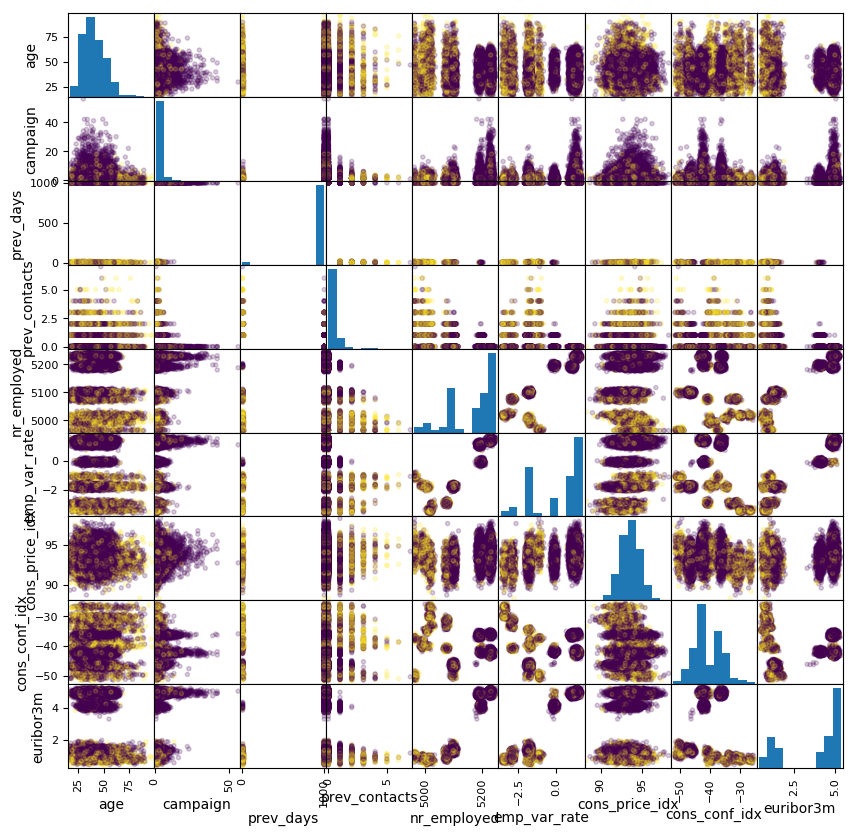

In [7]:
pd.tools.plotting.scatter_matrix(X_train[continuous], c=y_train, alpha=.2, figsize=(10, 10));

A few observations we see from the scatter matrix above:
* majority of clients are in their 30's (`age`).
* negative correlation between `nr_employed` and `prev_contacts`: clients with less number of employees tend to receive higher number of contacts before a specific campaign
* those who are younger (`age`) tends to have higher number of employees (`nr_employed`)

#### Density Plots
We also used density plots below to visualize the distribution of those who subscribed and those who did not subscribed (y-axis) for each continuous variable (x-axis). The kernel gaussian density is used to draw inferences about the population of those who subscribed vs. those who didn't.

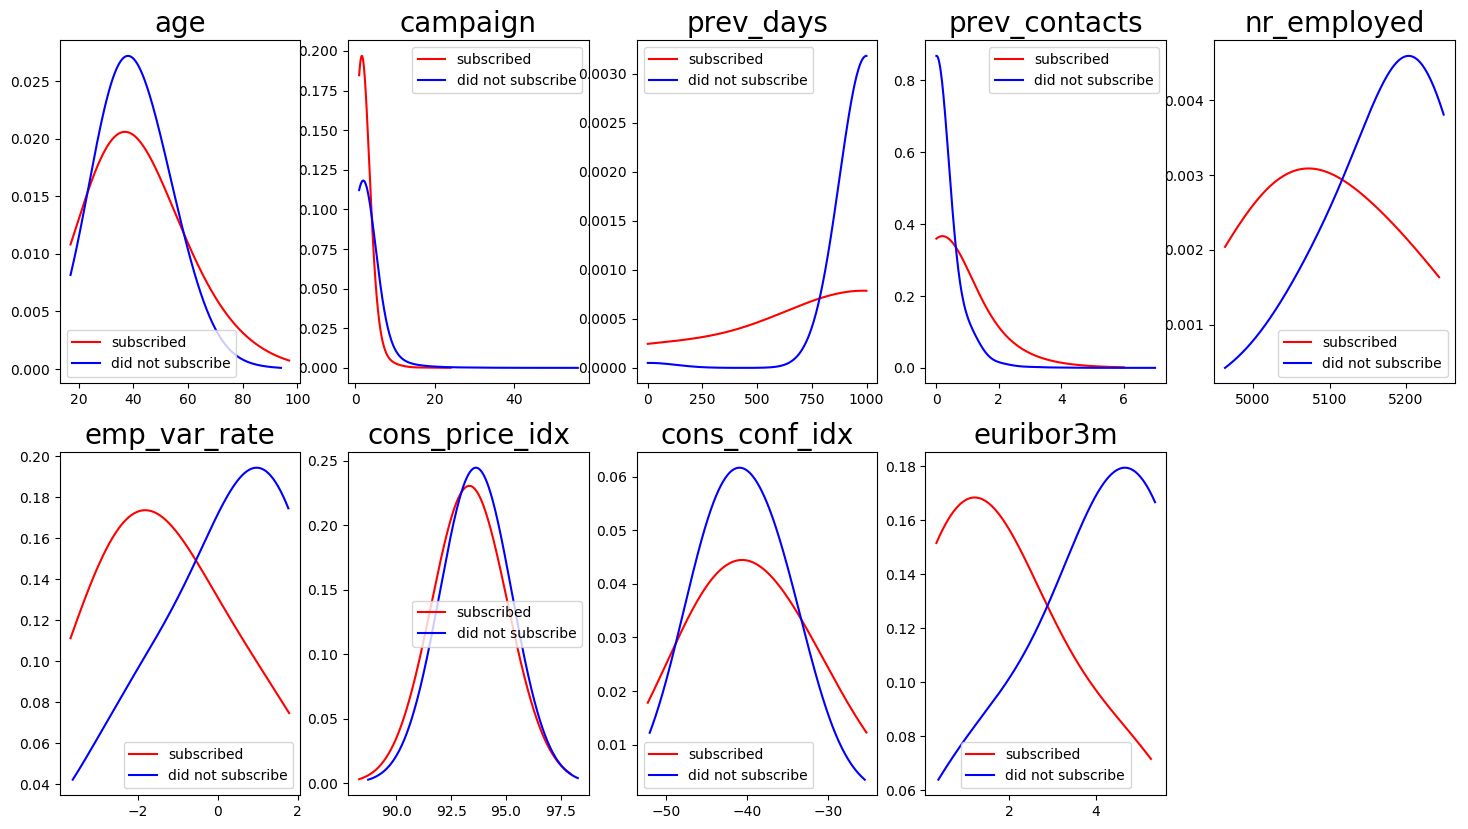

In [8]:
from scipy.stats import gaussian_kde

def density_calc(array, N = 500, bw = 0.2):
    """
    Parameters
    ----------
    array   :       array-like, data to be plotted as density
    N       :       int, number of points to use to generate density curve
    bw      :       float, corresponds to bandwidth, smaller results in skinnier bands.  
                    larger value results in wider bands
    Outputs
    -------
    x       :      array created from np.linspace
    density :      points of the density curve created with scipy.stats.gaussian_kde
    """
    density = gaussian_kde(array)
    x = np.linspace(np.min(array), np.max(array), N)
    density.covariance_factor = lambda: bw
    density._compute_covariance()
    return x, density(x)

def plot_density(values, bw = 0.2, N = 500):
    """
    Parameters
    ----------
    values       :       list, corresponds to columns in data table to plot
    bw           :       float, bandwidth parameter to be given to density_calc
    N            :       int, number of points used to generate density in density_calc    
    categorical  :       if data is categorical, ie non-integer/non-float then
                         create integer dummy variables
    Output
    ------
    Array of plots for density functions
    """
    df = data.copy() 
    fig = plt.figure(figsize=(2*len(values),10))
    for i,value in enumerate(values):
        axes = fig.add_subplot(2, len(values)/2+1, i+1)
        
        x, y = density_calc(df[str(value)][df["subscribed"] == "yes"], bw = bw)
        axes.plot(x, y, 'r', label='subscribed')

        x, y = density_calc(df[str(value)][df["subscribed"] == "no"], bw = bw)
        axes.plot(x, y, 'b', label='did not subscribe')
        axes.legend()
        axes.set_title(value)
        axes.title.set_fontsize(20)
    plt.show()
    
plot_density(continuous, bw=1)

Observations from the density plot above indicate that clients were *less likely* to subscribe when they had:
* higher the number of employees (`nr_employed`)
* higher the employment variation rate (`emp_var_rate`)
* higher euribor 3-month rate (`euribor3m`)

It's also interesting to see that in `campaign`, `age`, and `cons_price_idx` (consumer price index), the behaviors of clients who are likely to subscribe and not subcribe are quite similar.

#### Histograms
To observe the variables further, we can use histogram as follows. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A1D3978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000D825A90>]], dtype=object)

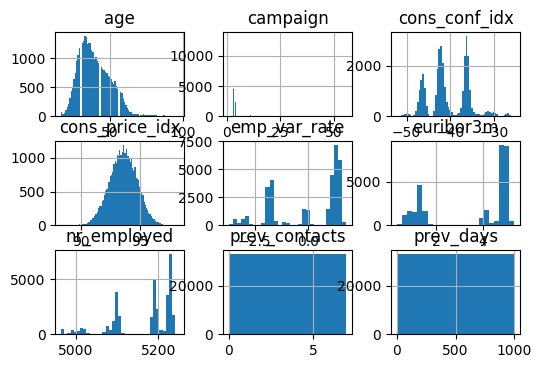

In [9]:
data_.hist(bins='auto')

Some observations can also be drawn:
* most data points in `prev_days` represent 999 values, which mean means most clients were not previously contacted
* `cons_price_idx` looks normally distributed
* `age` distribution looks right-skewed
* `cons_conf_idx` has three modes (trimodal distribution)
* interesting pattern in `prev_contacts`
* left skewed distribution with large gaps in `nr_employed`

### 2. Convert yes/no values to 1/0

First, we encode 1 for all categorical variables with `yes` values and 0 for `no` values.

In [10]:
def replace_non_numeric(df):
    """
    Parameters
    ----------
    df        :    Pandas dataframe of our data
    
    
    Returns
    -------
    df1       :    Pandas dataframe with yes/no answers transformed to 1/0 respectively
    
    """
    df1 = df.copy()
    yn_vars = ['credit_default', 'housing', 'loan']

    for dummy in yn_vars:
        df1[dummy] = df1[dummy].apply(lambda item: 0 if item == 'no' else item)
        df1[dummy] = df1[dummy].apply(lambda item: 1 if item == 'yes' else item)
        
    return df1

X_train_1 = replace_non_numeric(X_train)
X_test_1 = replace_non_numeric(X_test)

In [11]:
X_train_1.head()

age           job marital_status          education  credit_default  \
12353  52.0   blue-collar        married           basic.4y             NaN   
29303  41.0   blue-collar         single           basic.6y             NaN   
2965   36.0  entrepreneur         single  university.degree             0.0   
26504  46.0   blue-collar       divorced                NaN             0.0   
23299  51.0    management        married  university.degree             0.0   

       housing  loan    contact month day_of_week  campaign  prev_days  \
12353      0.0   0.0  telephone   may         thu      15.0        999   
29303      1.0   0.0   cellular   apr         fri       4.0        999   
2965       1.0   0.0  telephone   jun         fri       1.0        999   
26504      0.0   0.0   cellular   jul         tue       8.0        999   
23299      1.0   0.0  telephone   jun         fri       3.0        999   

       prev_contacts prev_outcomes  emp_var_rate  cons_price_idx  \
12353              0   nonexistent      1.178261       94.236694   
29303              1       failure     -2.000945       94.103725   
2965               0   nonexistent      1.331550       94.790008   
26504              0   nonexistent      1.335875       94.525150   
23299              0   nonexistent      1.468371       94.173802   

       cons_conf_idx  euribor3m  nr_employed  
12353     -37.048583   4.746075       5192.0  
29303     -46.096535   1.427209       5096.0  
2965      -41.728380   4.990515       5227.0  
26504     -42.931450   5.070245       5233.0  
23299     -42.645052   5.113962       5228.0

In [12]:
X_test_1.head()

age            job marital_status    education  credit_default  \
8475   39.0  self-employed        married  high.school             0.0   
25420  47.0   entrepreneur        married     basic.4y             NaN   
954    53.0      housemaid        married     basic.4y             NaN   
31356  36.0    blue-collar        married  high.school             NaN   
28161  60.0    blue-collar        married     basic.9y             NaN   

       housing  loan    contact month day_of_week  campaign  prev_days  \
8475       0.0   0.0  telephone   may         fri       8.0        999   
25420      0.0   0.0   cellular   aug         thu       1.0        999   
954        0.0   1.0   cellular   jul         wed       3.0        999   
31356      1.0   0.0   cellular   jul         tue       1.0        999   
28161      0.0   0.0   cellular   jul         fri       1.0        999   

       prev_contacts prev_outcomes  emp_var_rate  cons_price_idx  \
8475               0   nonexistent      1.005332       95.566634   
25420              0   nonexistent      1.403108       93.184728   
954                0   nonexistent      1.493933       93.452199   
31356              0   nonexistent      1.248770       93.930201   
28161              0   nonexistent      1.322459       93.690272   

       cons_conf_idx  euribor3m  nr_employed  
8475      -36.189834   4.941764       5193.0  
25420     -36.516203   4.844983       5231.0  
954       -42.725579   5.034550       5224.0  
31356     -42.320884   4.790487       5226.0  
28161     -42.332641   4.812160       5230.0

### 3. Create dummies for categorical variables

We can now perform one-hot-encoding technique to create dummies for other categorical variables. We perform one-hot-encoding to data containing both training and test set to ensure categorical variables are represented in the same way in both of these sets.

In [13]:
X_train = pd.get_dummies(X_train_1)
X_test = pd.get_dummies(X_test_1)

column_names = X_train.columns

print("Size for X_train:", X_train.shape)
print("Size for X_test:", X_test.shape)

Size for X_train: (24712, 53)
Size for X_test: (8238, 53)


In [14]:
X_train.head()

age  credit_default  housing  loan  campaign  prev_days  \
12353  52.0             NaN      0.0   0.0      15.0        999   
29303  41.0             NaN      1.0   0.0       4.0        999   
2965   36.0             0.0      1.0   0.0       1.0        999   
26504  46.0             0.0      0.0   0.0       8.0        999   
23299  51.0             0.0      1.0   0.0       3.0        999   

       prev_contacts  emp_var_rate  cons_price_idx  cons_conf_idx  \
12353              0      1.178261       94.236694     -37.048583   
29303              1     -2.000945       94.103725     -46.096535   
2965               0      1.331550       94.790008     -41.728380   
26504              0      1.335875       94.525150     -42.931450   
23299              0      1.468371       94.173802     -42.645052   

               ...            month_oct  month_sep  day_of_week_fri  \
12353          ...                    0          0                0   
29303          ...                    0          0                1   
2965           ...                    0          0                1   
26504          ...                    0          0                0   
23299          ...                    0          0                1   

       day_of_week_mon  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
12353                0                1                0                0   
29303                0                0                0                0   
2965                 0                0                0                0   
26504                0                0                1                0   
23299                0                0                0                0   

       prev_outcomes_failure  prev_outcomes_nonexistent  prev_outcomes_success  
12353                      0                          1                      0  
29303                      1                          0                      0  
2965                       0                          1                      0  
26504                      0                          1                      0  
23299                      0                          1                      0  

[5 rows x 53 columns]

### 4. Imputing missing values

With our split dataset, we want to impute missing data for variables containing null values. Six out of 19 features have missing values.

In [15]:
data.isnull().any()

age               False
job                True
marital_status     True
education          True
credit_default     True
housing            True
loan               True
contact           False
month             False
day_of_week       False
duration          False
campaign          False
prev_days         False
prev_contacts     False
prev_outcomes     False
emp_var_rate      False
cons_price_idx    False
cons_conf_idx     False
euribor3m         False
nr_employed       False
subscribed        False
dtype: bool

Check counts on features with missing values:

In [16]:
null_features = data.isnull().any()

for i in range(len(null_features)):
    if null_features[i]:
        print(data[data.columns[i]].isnull().value_counts())

False    32689
True       261
Name: job, dtype: int64
False    32887
True        63
Name: marital_status, dtype: int64
False    31556
True      1394
Name: education, dtype: int64
False    26062
True      6888
Name: credit_default, dtype: int64
False    32150
True       800
Name: housing, dtype: int64
False    32150
True       800
Name: loan, dtype: int64


We see that all missing values are in categorical variables, so we can perform Imputer's **most frequent** strategy. Some observation: `education` and `marital_status` variables have larger number of missing values. 

In [17]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(X_train)
X_test = pd.DataFrame(imp.transform(X_test))
X_train = pd.DataFrame(imp.transform(X_train))

In [18]:
X_train.head()

0    1    2    3     4      5    6         7          8          9  ...   \
0  52.0  0.0  0.0  0.0  15.0  999.0  0.0  1.178261  94.236694 -37.048583 ...    
1  41.0  0.0  1.0  0.0   4.0  999.0  1.0 -2.000945  94.103725 -46.096535 ...    
2  36.0  0.0  1.0  0.0   1.0  999.0  0.0  1.331550  94.790008 -41.728380 ...    
3  46.0  0.0  0.0  0.0   8.0  999.0  0.0  1.335875  94.525150 -42.931450 ...    
4  51.0  0.0  1.0  0.0   3.0  999.0  0.0  1.468371  94.173802 -42.645052 ...    

    43   44   45   46   47   48   49   50   51   52  
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[5 rows x 53 columns]

### 5. Dealing with imbalanced data

In [19]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)
print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [False]
Test score: 0.89


We see here that even without any models, we would get 0.89 of accuracy. Although it seems to be a very good performance, the accuracy is only reflecting the underlying class distribution -- therefore the data is imbalanced. There is actually far too many datapoints in [0] class than [1] class. So the problem that may come up is that the model we perform can always predict the majority class, in this case [0].

We will deal with imbalanced data using undersampling, oversampling, and resampled ensemble in the next steps.

#### Undersample
* Random Undersampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(24712, 53)
(5568, 53)
[2784 2784]


* Using Pipeline for Undersampling

In [21]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring = 'roc_auc')
print(np.mean(scores), scores)

0.78059534358 [ 0.808  0.779  0.761  0.788  0.781  0.772  0.762  0.8    0.794  0.761]


#### Oversample
* Random Oversampling

In [22]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(24712, 53)
(43856, 53)
[21928 21928]


* Using Pipeline for Oversampling

In [23]:
from sklearn.linear_model import LogisticRegression
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegressionCV())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores), scores)

0.782194092304 [ 0.812  0.779  0.759  0.79   0.786  0.774  0.767  0.795  0.791  0.769]


* Synthetic Minority Over-sampling (SMOTE)

In [24]:
from imblearn import over_sampling, under_sampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.1, 0.9], n_informative=3, 
                           n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1, 
                           n_samples=1000, random_state=10)

print('Original dataset shape {}'.format(Counter(y)))

#sm_pipe = make_imb_pipeline(SMOTE(random_state = 42), classifier)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 900, 0: 100})
Resampled dataset shape Counter({False: 21928, True: 21928})


### ROC Curve

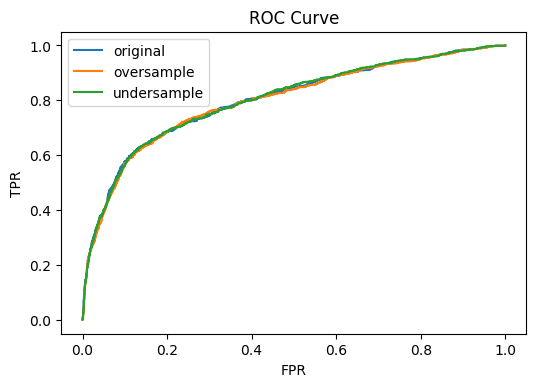

In [25]:
from sklearn.metrics import roc_curve
oversample_pipe.fit(X_train, y_train)
props_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, props_oversample)

undersample_pipe.fit(X_train, y_train)
props_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, props_undersample)

lr = LogisticRegression().fit(X_train, y_train)
props_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, props_original)

plt.plot(fpr_org, tpr_org, label="original")
plt.plot(fpr_over, tpr_over, label="oversample")
plt.plot(fpr_under, tpr_under, label="undersample")
plt.legend()
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

### Edited Nearest Neighbors for Outlier Removal

In [37]:
param_grid = {'editednearestneighbours__n_neighbors': [1,3,5,7],
              'editednearestneighbours__kind_sel': ['all', 'mode']}

pipe = make_imb_pipeline(EditedNearestNeighbours(), LogisticRegression())
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.score(X_train, y_train))


{'editednearestneighbours__kind_sel': 'all', 'editednearestneighbours__n_neighbors': 3}
0.784579486496


As performance metrics we will use sensitivity, specificity and AUC. and f1-score!!

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [258]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB

from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE 

from collections import Counter
from sklearn.datasets import make_classification

### 2.1. Logistic Regression

For logistic regression, we used `PolynomialFeatures` to create more features in the model, which had a higher score than having an additional feature selection such as `SelectPercentile`. We also used `MinMaxScaler` to subtract minimum and divide by range. Afterwards between 0 and 1. `RandomUnderSampler` was used to deal with imbalanced data.

In [30]:
start = time.clock()

param_grid = {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10, 100]}

us_lr = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), PolynomialFeatures(include_bias=False), LogisticRegression())

scores = cross_val_score(us_lr, X_train, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search = GridSearchCV(us_lr, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

log_reg = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), LogisticRegression(C=0.01))

[ 0.771  0.755  0.728  0.788  0.76   0.74   0.751  0.781  0.79   0.738]
Accuracy on training set: 0.80
Accuracy on test set: 0.81
{'logisticregression__C': 0.01}
Execution time: 56.79439163028836 seconds.


### 2.2. Linear SVM

We used `SelectPercentile` to select a fixed percentage of features and `RobustScaler` to subtract minimum and divide by range. Afterwards between 0 and 1. `RandomUnderSample` was used to deal with imbalanced data.

In [ ]:
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
#Timed to 0.113 minutes to fit per model w/ full dataset

#l1 penalty not supported using dual optimization due to non-convexity
start = time.clock()

param_grid = {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100]}

us_lsvc = make_imb_pipeline(RandomUnderSampler(), RobustScaler(), LinearSVC())

scores = cross_val_score(us_lsvc, X_train_selected, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search = GridSearchCV(us_lsvc, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_selected, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search.score(X_train_selected, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search.score(X_test_selected, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

### 2.3 Stochastic Gradient Descent Classifier

We used `SelectPercentile` to select a fixed percentage of features and `RobustScaler` to subtract minimum and divide by range. Afterwards between 0 and 1. `RandomUnderSample` was used to deal with imbalanced data.

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
from sklearn.utils import gen_batches, shuffle
from sklearn.linear_model import SGDClassifier

batches = [(X_train_selected[batch], y_train[batch]) for batch in gen_batches(X_train.shape[0], 10)]

sgd = SGDClassifier(loss = 'modified_huber')
for i in range(10):
    for X_batch, y_batch in batches:
        sgd.partial_fit(X_batch, y_batch, classes=[0, 1, 2])
sgd.score(X_test_selected, y_test)

sgd_params = {'sgdclassifier__penalty': ['elasticnet', 'l1', 'l2'], 
              'sgdclassifier__loss': ['modified_huber']}
sgd_pipe = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), SGDClassifier())

grid = GridSearchCV(sgd_pipe, sgd_params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

print(grid.score(X_train, y_train))
print(grid.score(X_test, y_test))
print(grid.best_params_)


### 2.4. Nearest Centroid Classifier

We used `SelectKBest` to select a fixed percentage of features and `RobustScaler` to subtract minimum and divide by range. Afterwards between 0 and 1. `RandomUnderSample` was used to deal with imbalanced data.

In [ ]:
from sklearn.feature_selection import SelectKBest
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectKBest(k=10)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
start = time.clock()

param_grid = {'nearestcentroid__metric': ['manhattan', 'euclidean'],
              'nearestcentroid__shrink_threshold': [None, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,1000.0]}

rus_sc = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), NearestCentroid())

grid_search = GridSearchCV(rus_sc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search.score(X_test, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

### 2.5. Edited Nearest Neighbours

### 2.6. Logistic Regression with Resampled Ensemble

Feature engineering includes adding `PolynomialFeatures`, `soft voting`, `MinMaxScaler`, and resampled ensemble.

In [ ]:
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier

def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 MinMaxScaler(), PolynomialFeatures(include_bias=False),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [ ]:
resampled_lr = make_resampled_ensemble(LogisticRegression())

scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

### 2.7. Logistic Regression with RFE

For logistic regression, we used `PolynomialFeatures` to create more features in the model, which had a higher score than having an additional feature selection such as `SelectPercentile`. We also used `MinMaxScaler` to subtract minimum and divide by range. Afterwards between 0 and 1. `RandomUnderSampler` was used to deal with imbalanced data.

In [ ]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
n_features_to_select=40)
select.fit(X_train, y_train)

X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)

In [ ]:
start = time.clock()

param_grid = {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10]}

us_lr = make_imb_pipeline(RandomUnderSampler(random_state=2), MinMaxScaler(), PolynomialFeatures(), LogisticRegression(random_state=42))

scores = cross_val_score(us_lr, X_train_rfe, y_train, cv=10, scoring = 'roc_auc')
print(scores)

grid_search = GridSearchCV(us_lr, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rfe, y_train)

end = time.clock()

print("Accuracy on training set: {:.2f}".format(grid_search.score(X_train_rfe, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search.score(X_test_rfe, y_test)))
print(grid_search.best_params_)

print("Execution time:",str(float(end-start)),"seconds.")

### 2.8. SVM with RBF kernel

In [ ]:
pipe_rbf = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), SVC(probability=True))

grid = GridSearchCV(pipe_rbf, cv=10, param_grid = {}, scoring='roc_auc')
grid.fit(X_train, y_train)
print(grid.score(X_train, y_train), '\n', grid.score(X_test, y_test))
score = cross_val_score(pipe_rbf, X_train, y_train, cv=10, scoring = 'roc_auc')
print(scores, '\n', np.mean(scores))

### 2.9. Naive Bayes

In [ ]:
pipe_nb = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), GaussianNB())
scores = cross_val_score(pipe_nb, X_train_selected, y_train, cv=10)
print(np.mean(scores))

scores = cross_val_score(pipe_nb, X_train, y_train, cv=10)
print(np.mean(scores))

# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [32]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

### 3.1. Decision Tree

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))# transform test data
X_test_selected = select.transform(X_test) 

In [ ]:
param_grid_dtc = {'decisiontreeclassifier__criterion':['gini', 'entropy'],
                  'decisiontreeclassifier__max_leaf_nodes': [None, 2, 4, 6, 8, 10, 50],
                  'decisiontreeclassifier__max_depth':[None, 10, 50]}


pipe_rtt = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), DecisionTreeClassifier())

grid = GridSearchCV(pipe_rtt, param_grid = param_grid_dtc, cv=5, scoring = 'roc_auc')
grid.fit(X_train_selected, y_train)
print(grid.best_params_)
print(grid.score(X_train_selected, y_train))
print(grid.score(X_test_selected, y_test))

### 3.2. Random Forest

For Random Forest, we use `RFE` classifier as an interative feature selection.

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
param_grid_RF = { "randomforestclassifier__n_estimators": [4,8,10,15,20,25,30,35],
           "randomforestclassifier__criterion"          : ["gini", "entropy"],
           "randomforestclassifier__max_features"       : [2,3],
           "randomforestclassifier__max_depth"          : [5,10],
           "randomforestclassifier__min_samples_split"  : [3,2] ,
           "randomforestclassifier__bootstrap"          : [True, False]}

rus = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), RandomForestClassifier(random_state=2))

grid_search_RF = GridSearchCV(rus, param_grid_RF, n_jobs=-1, cv=10, scoring="roc_auc")
grid_search_RF.fit(X_train_selected, y_train)
print(grid_search_RF.best_params_)

print("Accuracy on training set: {:.2f}".format(grid_search_RF.score(X_train_selected, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_search_RF.score(X_test_selected, y_test)))

### 3.3. Bagging

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5, random_state=2)

param_grid = {"baggingclassifier__n_estimators" : range(5,25,10)}

rus = make_imb_pipeline(RandomOverSampler(), MinMaxScaler(), bagging)

grid = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid.fit(X_train_selected, y_train)

print("Accuracy on training set: {:.2f}".format(grid.score(X_train_selected, y_train)))
print("Accuracy on test set: {:.2f}".format(grid.score(X_test_selected, y_test)))

### 3.4. Gradient Boosting

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))# transform test data
X_test_selected = select.transform(X_test) 

In [186]:
param_grid_gbrt = {'gradientboostingclassifier__min_impurity_split': [1*10**-5],
                   'gradientboostingclassifier__max_leaf_nodes': [None],
                   'gradientboostingclassifier__max_depth': [12],
                   'gradientboostingclassifier__max_features': [None]}



pipe_gbrt = make_imb_pipeline(RandomUnderSampler(), StandardScaler(), GradientBoostingClassifier())

grid = GridSearchCV(pipe_gbrt, param_grid = param_grid_gbrt, cv=5, scoring='roc_auc')
grid.fit(X_train_both, y_train_both)

print("Accuracy on training set: {:.2f}".format(grid.score(X_train_both, y_train_both)))
print("Accuracy on test set: {:.2f}".format(grid.score(X_test_both, y_test)))
print("Best Parameters:", grid.best_params_)

Accuracy on training set: 0.99
Accuracy on test set: 0.79
Best Parameters: {'gradientboostingclassifier__max_features': None, 'gradientboostingclassifier__min_impurity_split': 1e-05, 'gradientboostingclassifier__max_leaf_nodes': None, 'gradientboostingclassifier__max_depth': 12}


### 3.5. Extra Tree Classifier

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=60)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [110]:
param_grid = {'extratreeclassifier__criterion': ['gini', 'entropy'],
              'extratreeclassifier__max_leaf_nodes': [None, 10, 50],
              'extratreeclassifier__max_depth':[None, 10, 50],
              'extratreeclassifier__max_features':[None, 26]}

rus = make_imb_pipeline(RandomUnderSampler(), MinMaxScaler(), ExtraTreeClassifier())

grid = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid.fit(X_train_rus, y_train_rus)

print("Accuracy on training set: {:.2f}".format(grid.score(X_train_rus, y_train_rus)))
print("Accuracy on test set: {:.2f}".format(grid.score(X_test_rus, y_test)))
print(grid.best_params_)

etc = ExtraTreeClassifier(max_features = 25,
                          max_depth = None,
                          max_leaf_nodes = 10)

Accuracy on training set: 0.82
Accuracy on test set: 0.80
{'extratreeclassifier__max_features': None, 'extratreeclassifier__criterion': 'gini', 'extratreeclassifier__max_depth': 10, 'extratreeclassifier__max_leaf_nodes': 10}


### 3.6. Adaboost

In [ ]:
from sklearn.feature_selection import SelectPercentile
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

# transform test data
X_test_selected = select.transform(X_test)

In [ ]:
param_grid = {"adaboostclassifier__n_estimators" : range(10,50,5), 
              "adaboostclassifier__learning_rate" : np.logspace(-3,1,10)}

rus = make_imb_pipeline(RandomOverSampler(), MinMaxScaler(), AdaBoostClassifier())

grid_ABC = GridSearchCV(rus, param_grid=param_grid, cv=10, scoring = 'roc_auc')
grid_ABC.fit(X_train_selected, y_train)

print("Accuracy on training set: {:.2f}".format(grid_ABC.score(X_train_selected, y_train)))
print("Accuracy on test set: {:.2f}".format(grid_ABC.score(X_test_selected, y_test)))

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [171]:
def transform_data(X, y, xtest = None,
                   outlier_removal = EditedNearestNeighbours(n_neighbors = 3),
                   undersampler = None, 
                   oversampler = None, 
                   selector = None, 
                   scalor = MinMaxScaler(), 
                   polynomialfeatures = False, p=2):
    """
    
    
    
    
    
    
    """
    if outlier_removal is not None:
        outlier_removal.fit(X,y)
        X, y = outlier_removal.sample(X,y)
        
    if oversampler is not None:
        oversampler.fit(X, y)
        X, y = oversampler.sample(X, y)
        
    if undersampler is not None:
        undersampler.fit(X, y)
        X, y = undersampler.sample(X,y)
        
    if scalor is not None:
        scalor.fit(X)
        X = scalor.transform(X)
        
    if polynomialfeatures:
        pf = PolynomialFeatures(degree=p, include_bias=False).fit(X)
        X = pf.transform(X)
        
    if selector is not None:
        selector.fit(X, y)
        X = selector.transform(X)
        
    if xtest is not None:
        xtest = scalor.transform(xtest)
        if polynomialfeatures:
            xtest = pf.transform(xtest)
        if selector is not None:
            xtest = selector.transform(xtest)
        return X, y, xtest
        
    return X, y

In [265]:
X_train_both, y_train_both, X_test_both = transform_data(X_train, y_train, xtest = X_test,
                                                         oversampler = SMOTE(0.4), 
                                                         undersampler=RandomUnderSampler(), 
                                                         scalor = StandardScaler(),
                                                         selector = SelectPercentile(percentile=50))

X_train_rus, y_train_rus, X_test_rus = transform_data(X_train, y_train, xtest = X_test,
                                                      undersampler = RandomUnderSampler(),
                                                      scalor = StandardScaler(),
                                                      selector = SelectPercentile(percentile=50))

X_train_smote, y_train_smote, X_test_smote = transform_data(X_train, y_train, xtest = X_test,
                                                            oversampler = SMOTE(0.75),
                                                            scalor = StandardScaler(),
                                                            selector = SelectPercentile(percentile=50))

C:\ProgramData\Anaconda2\envs\py34\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [1] are constant.
  UserWarning)
C:\ProgramData\Anaconda2\envs\py34\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(23971, 26) (16482, 16) (8238,)


TypeError: fit() missing 1 required positional argument: 'y'

In [182]:
print("Accuracy on training set: {:.2f}".format(grid.score(X_train_both, y_train_both)))
print("Accuracy on test set: {:.2f}".format(grid.score(X_test_both, y_test)))
print(grid.best_params_)

Accuracy on training set: 0.99
Accuracy on test set: 0.79
{'gradientboostingclassifier__max_features': None, 'gradientboostingclassifier__min_impurity_split': 1e-05, 'gradientboostingclassifier__max_leaf_nodes': None, 'gradientboostingclassifier__max_depth': 12}


In [261]:
#Poor Mans Stacking
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,6)[:, 1::2], validate=False)

#AdaBoost, RandomForest, NaiveBayes, SVC with rbf kernel, logistic regression
log_reg = LogisticRegression(C=10)

svc = SVC(C=0.01, probability=True)

rf = RandomForestClassifier(random_state=42,
                            bootstrap = False,
                            criterion = 'entropy',
                            max_depth = 10,
                            max_features = 3,
                            min_samples_split = 2,
                            n_estimators = 30)

ada = AdaBoostClassifier(n_estimators = 35,
                         learning_rate = 0.4642)

nb = GaussianNB()

etc = ExtraTreeClassifier()

gbrt = GradientBoostingClassifier(min_impurity_split = 1*10**-5,
                                  max_depth = 12)

ada_etc = AdaBoostClassifier(etc, n_estimators=3)



voting = VotingClassifier([('log_reg', log_reg),
                           ('GBRT', gbrt),
                            ('nb', nb)],
                          voting = 'soft')

scores = cross_val_score(voting, X_train, y_train, cv=10, scoring = 'roc_auc')
print(np.mean(scores))
print(X_train_smote.shape, y_train_smote.shape)
stacking = make_pipeline(voting, reshaper, LogisticRegression(C=0.001))
stacking.fit(X_train_smote, y_train_smote)

#Do Nothing Scores
print(stacking.score(X_train_smote, y_train_smote))
print(stacking.score(X_test_smote, y_test))

stack = stacking.predict_proba(X_test_smote)

y_score = pd.DataFrame(stacking.predict_proba(X_test_smote))[1]
print("test roc-auc", roc_auc_score(y_test, y_score))

assert(roc_auc_score(y_test, y_score) >= 0.795)

0.826353482102
(23971, 26) (23971,)
0.991489716741
0.855668851663
test roc-auc 0.804695386575


In [192]:
stacking.fit(X_train, y_train)
print("do nothing and stack:", stacking.score(X_train, y_train))
print("do nothing and stack:", stacking.score(X_test, y_test))

stacking.fit(X_train_rus, y_train_rus)
print("\nstacking on rus set:", stacking.score(X_train_rus, y_train_rus))
print("stacking on rus test set:", stacking.score(X_test_rus, y_test))

stacking.fit(X_train_smote, y_train_smote)
print("\nstacking on smote set:", stacking.score(X_train_smote, y_train_smote))
print("stacking on smote test set:", stacking.score(X_test_smote, y_test))

stacking.fit(X_train_both, y_train_both)
print("\nstacking on both rus and smote set:", stacking.score(X_train_both, y_train_both))
print("stacking on both test set:", stacking.score(X_test_both, y_test))


do nothing and stack: 0.999849359779
do nothing and stack: 0.860403010439

stacking on rus set: 1.0
stacking on rus test set: 0.721777130371

stacking on smote set: 0.999582833603
stacking on smote test set: 0.840738043214

stacking on both rus and smote set: 1.0
stacking on both test set: 0.766205389658


In [194]:
#Easy Ensemble from Slides
from sklearn.base import clone

X_train_t, y_train_t, X_test_t = transform_data(X_train, y_train, xtest= X_test,
                                                scalor = MinMaxScaler(),
                                          selector = SelectPercentile(percentile=50))

def make_resampled_ensemble(estimator, n_estimators = 100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state = i, replacement = True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting='soft')


voting = VotingClassifier([('log_reg', log_reg),
                           ('GBRT', gbrt)],
                          voting = 'soft')

n = 20
reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,2*n)[:, 1::2], validate=False)
easy_voting = make_resampled_ensemble(voting, n_estimators = n)

stacking_2 = make_pipeline(easy_voting, reshaper, LogisticRegression(C=100))

stacking_2.fit(X_train_smote, y_train_smote)

print("Stacking Easy Ensemble train:", stacking_2.score(X_train_smote, y_train_smote))
print("Stacking Easy Ensemble test:", stacking_2.score(X_test_smote, y_test))

from sklearn.metrics import roc_auc_score

y_score = pd.DataFrame(stacking_2.predict_proba(X_test_smote))[1]
print("test roc-auc", roc_auc_score(y_test, y_score))

y_score = pd.DataFrame(stacking_2.predict_proba(X_train_smote))[1]
print("train roc-auc", roc_auc_score(y_train_smote, y_score))

Stacking Easy Ensemble train: 0.965531626427
Stacking Easy Ensemble test: 0.8245933479
test roc-auc 0.809005289165
train roc-auc 0.992876649694


iteration 2 time 25.099926655711897
iteration 3 time 35.456064655809314
iteration 4 time 46.93148797224421
iteration 5 time 57.905887994813384


KeyboardInterrupt: 

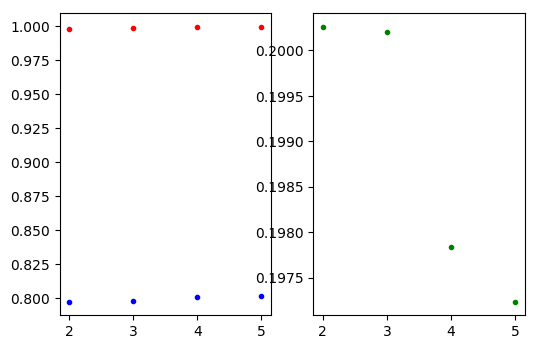

In [198]:
# transform X_train with feature selection and 
X_train_t, y_train_t, X_test_t = transform_data(X_train, y_train, xtest= X_test,
                                          selector = SelectPercentile(percentile=50))

select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

fig = plt.figure()
axes_1=fig.add_subplot(1,2,1)
axes_2 = fig.add_subplot(1,2,2)
total_time = 0
for n in range(2,20):
    start = time.clock()
    
    easy_voting = make_resampled_ensemble(gbrt, n_estimators = n)
    reshaper = FunctionTransformer(lambda X_: np.rollaxis(X_, 1).reshape(-1,2*n)[:, 1::2], validate=False)
    stacking_2 = make_pipeline(easy_voting, reshaper, LogisticRegression(C=100))
    stacking_2.fit(X_train_smote, y_train_smote)
    
    y_score_test = pd.DataFrame(stacking_2.predict_proba(X_test_smote))[1]
    axes_1.plot(n, roc_auc_score(y_test, y_score_test), 'b.')
    
    y_score_train = pd.DataFrame(stacking_2.predict_proba(X_train_smote))[1]
    axes_1.plot(n, roc_auc_score(y_train_smote, y_score_train), 'r.')
    
    diff = roc_auc_score(y_train_smote, y_score_train) - roc_auc_score(y_test, y_score_test)
    axes_2.plot(n, diff, 'g.')
    
    end = time.clock()
    total_time += (end - start)
    print("iteration", n, "time", total_time)
    
plt.show()    

Wallace, B. C.; Small, K.; Brodley, C. E.; Trikalinos, T. A. Class Imbalance, Redux. Presented at the 11th International Converence on Data Mining (2011).  DOI 10.1109/ICDM.2011.33

Due to RandomUnderSampler's lack of weight feature, this method is difficult to implement without a custom model

In [136]:
pipe = make_imb_pipeline(RandomUnderSampler(), voting)
ada_voting = AdaBoostClassifier(voting, n_estimators=20)
ada_voting.fit(X_train, y_train)
print(ada_voting.score(X_train, y_train))
print(ada_voting.score(X_test, y_test))

0.934471503892
0.877518815246


iteration 2 time 0.08358921557373833
iteration 3 time 0.10566055699018762
iteration 4 time 0.13599935118691064
iteration 5 time 0.15149544771702494
iteration 6 time 0.18423027285462013
iteration 7 time 0.19703061418840662
iteration 8 time 0.23782555343495915
iteration 9 time 0.2628391291727894
iteration 10 time 0.2858085855114041
iteration 11 time 0.32845723111677216
iteration 12 time 0.32693463189934846
iteration 13 time 0.3743284413649235
iteration 14 time 0.4172285027234466
iteration 15 time 0.4678216041284031
iteration 16 time 0.4621539947911515
iteration 17 time 0.5799611416296102
iteration 18 time 0.508097138867015
iteration 19 time 0.5593334132645396
iteration 20 time 0.5518233813127154
iteration 21 time 0.5415830377241946
iteration 22 time 0.5882962968171341
iteration 23 time 0.6468074077711208
iteration 24 time 0.6638225773494923
iteration 25 time 0.7083309237859794
iteration 26 time 0.7964949893212179
iteration 27 time 0.7619917910778895
iteration 28 time 0.7439688427839428
i

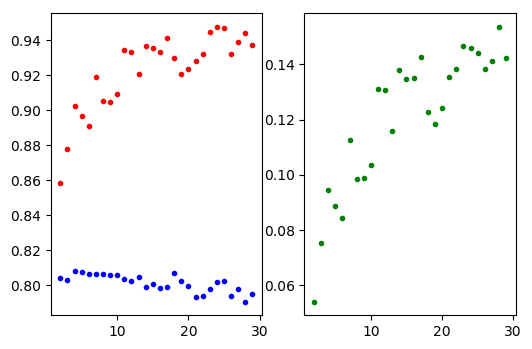

In [206]:
fig = plt.figure()
axes_1 = fig.add_subplot(1,2,1)
axes_2 = fig.add_subplot(1,2,2)
for n in range(2,30):
    total_time = 0
    start = time.clock()
    
    ada_voting = AdaBoostClassifier(etc, n_estimators=n)
    ada_voting.fit(X_train_smote, y_train_smote)
    
    y_score_test = pd.DataFrame(ada_voting.predict_proba(X_test_smote))[1]
    axes_1.plot(n, roc_auc_score(y_test, y_score_test), 'b.')
    
    y_score_train = pd.DataFrame(ada_voting.predict_proba(X_train_smote))[1]
    axes_1.plot(n, roc_auc_score(y_train_smote, y_score_train), 'r.')
    diff = roc_auc_score(y_train_smote, y_score_train) - roc_auc_score(y_test, y_score_test)
    axes_2.plot(n, diff, 'g.')
                                
    end = time.clock()
    total_time += (end - start)
    print("iteration", n, "time", total_time)
    
plt.show()    

### Predict Data
The following holdout set is for model evaluation.

In [ ]:
mf_pipe = make_pipeline(Imputer(missing_values='NaN', strategy='most_frequent', axis=0), StandardScaler(), LogisticRegression())
scores = cross_val_score(mf_pipe, X_train, y_train, cv=10)
np.mean(scores)

In [269]:
holdout = pd.read_csv('data/holdout.csv', delimiter = ',', na_values='unknown')
#print(holdout.dtypes)

ID = pd.Series([int(i) for i in holdout.ID])
# print(ID.dtypes)

holdit = holdout.drop(["ID", "duration"], axis = 1)

# holdit.head()

holdit = replace_non_numeric(holdit)

holdit = pd.get_dummies(holdit)

holdit = pd.DataFrame(imp.transform(holdit))
holdit = scaler.transform(holdit)
holdit = select.transform(holdit)

proba  = stacking.predict_proba(holdit)



features = pd.DataFrame(proba)[1]
# print(features.dtypes)

#X_test_f = predict_holdout('data/holdout.csv')
out = pd.concat([ID, features], axis=1)
out.columns = ["ID", "subscribed"]
out["ID"] = pd.to_numeric(out.ID)
#print(out.tail())
#print(out.dtypes)
#out.to_csv('holdout_pred2.csv', index = False)

        ID  subscribed
8233  4144    0.848603
8234  1269    0.761569
8235  4196    0.761569
8236  2999    0.796334
8237  1642    0.785662
ID              int64
subscribed    float64
dtype: object


C:\ProgramData\Anaconda2\envs\py34\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
